In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
# warnings.filterwarnings("ignore", category=np.DeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
def gen_lc(trainsize,testsize):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]

    with open('big_test_ind.pickle', 'rb') as handle:
        test_ind = pickle.load(handle)
    
    with open('big_train_ind.pickle', 'rb') as handle:
        train_ind = pickle.load(handle)
  
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind, train_size=trainsize, test_size=testsize,random_state=42)
    print(len(train_ind),len(test_ind))    
    
    train = []
    test = []
        
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    for i in sorted(glob('ANO-RCC-VTZP')):
        print(i)
        for j in glob(os.path.join(i,'ozone_*')):
            for k in train_ind:
                if f"{k:.2f}" in j:
                    traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                    train.append(traindf)
                    recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                    traincnt+=1
                    
            for l in test_ind:
                if f"{l:.2f}" in j:
                    testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                    test.append(testdf)                    
                    recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                    testcnt+=1
                    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
    'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
    'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
    'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
    'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
    'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
    'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
    'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
    'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
    'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
    'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
    'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
    'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
    'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
    'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
    'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
    'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
    'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
    'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
    'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
    'typ_0':'type_0',
    'typ_1':'type_1',
    'typ_2':'type_2',
    'typ_3':'type_3'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    kwargs = dict(pd.read_excel("ozone_VTZP_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for i,j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for i,j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in traincorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in testcorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [5]:
def plot(data,trainsize):
    pair_r2 = []
    pair_mae = []
    corr_r2 = []
    corr_mae = []
    for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
        traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
        traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']
    
        testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
        testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
        
        pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
        pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))
    
        corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
        corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))
    
    dfpair_r2 = pd.DataFrame(pair_r2,columns=['Train Size', "Train", "Test"])
    dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Train Size', "Train", "Test"])
    dfpair_mae = pd.DataFrame(pair_mae,columns=['Train Size', "Train", "Test"])
    dfcorr_mae = pd.DataFrame(corr_mae,columns=['Train Size', "Train", "Test"])
    
    
    fig, ax = plt.subplots(2,2,sharex=True)
    sns.lineplot(dfpair_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][0])
    sns.lineplot(dfcorr_r2.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[0][1],markers='x')
    ax[0][0].set_xlim(0,304)
    ax[0][1].set_xlim(0,304)
    ax[0][0].set_ylim(-.74,1.1)
    ax[0][1].set_ylim(-.74,1.1)
    ax[0][0].set_ylabel("R$^{2}$")
    ax[0][1].set_ylabel("R$^{2}$")
    sns.lineplot(dfpair_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][0])
    ax[1][0].set_ylim(0,1)
    sns.lineplot(dfcorr_mae.melt(id_vars='Train Size',value_vars=['Train','Test']),x='Train Size',y='value', hue='variable',ax=ax[1][1])
    ax[1][1].set_ylim(0,8)
    ax[1][0].set_ylabel("MAE (mE$_{h}$)")
    ax[1][1].set_ylabel("MAE (mE$_{h}$)")
    # plt.suptitle(f"{trainsize},{testsize}")
    plt.tight_layout()
    # plt.savefig('images/learning_curves.png',dpi=300,bbox_inches='tight')    

30 31
ANO-RCC-VTZP
R2: 0.9994,0.9125
RMSE (mEh): 0.2666,3.0973
60 31
ANO-RCC-VTZP
R2: 0.9995,0.9255
RMSE (mEh): 0.2306,2.8588
91 31
ANO-RCC-VTZP
R2: 0.9996,0.9913
RMSE (mEh): 0.2087,0.9767
121 31
ANO-RCC-VTZP
R2: 0.9996,0.9980
RMSE (mEh): 0.1973,0.4694
152 31
ANO-RCC-VTZP
R2: 0.9997,0.9956
RMSE (mEh): 0.1869,0.6957
182 31
ANO-RCC-VTZP
R2: 0.9997,0.9989
RMSE (mEh): 0.1891,0.3477
212 31
ANO-RCC-VTZP
R2: 0.9997,0.9996
RMSE (mEh): 0.1881,0.2213
243 31
ANO-RCC-VTZP
R2: 0.9997,0.9979
RMSE (mEh): 0.1809,0.4786
273 31
ANO-RCC-VTZP
R2: 0.9997,0.9997
RMSE (mEh): 0.1674,0.1921


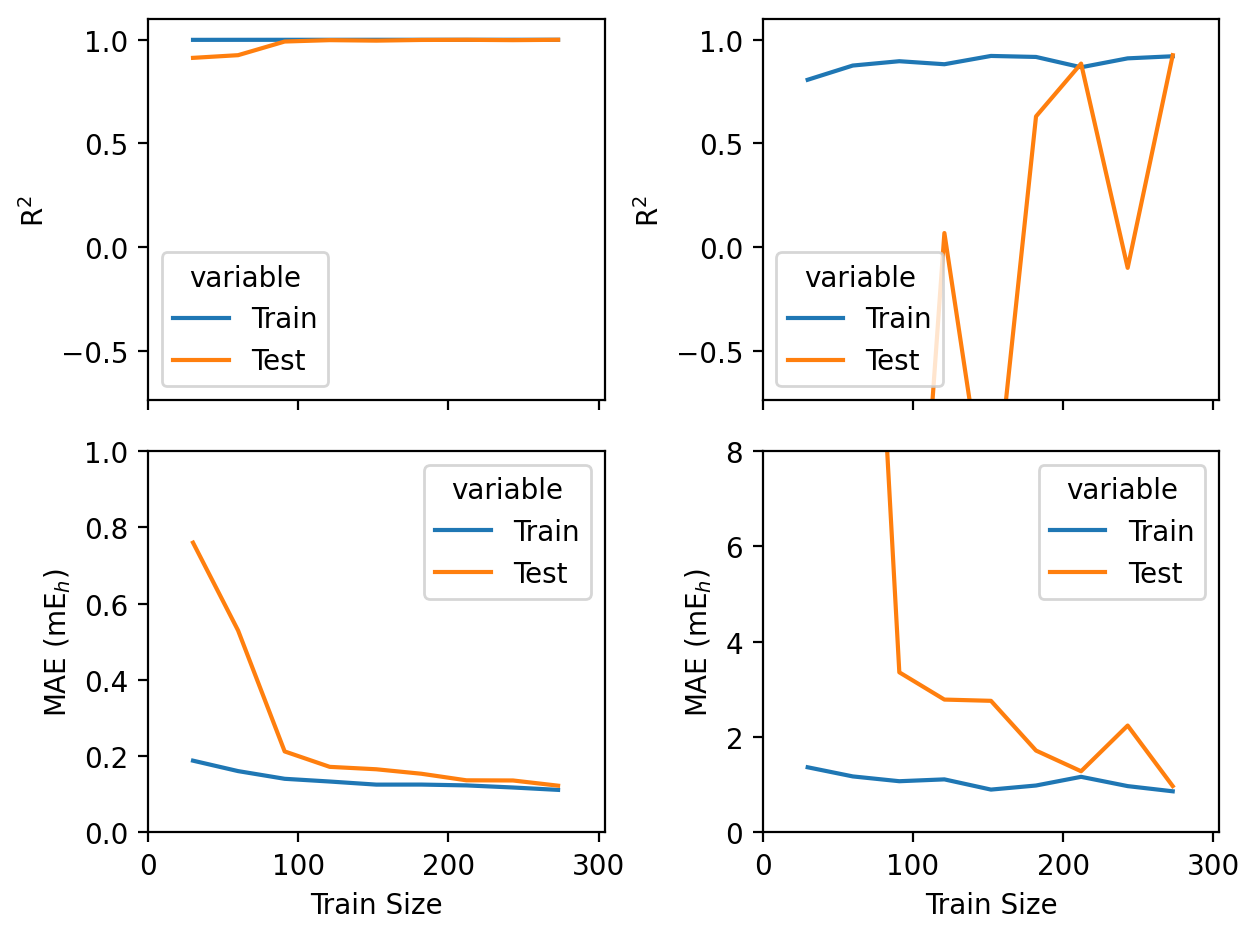

30 61
ANO-RCC-VTZP
R2: 0.9993,0.9502
RMSE (mEh): 0.2798,2.3467
60 61
ANO-RCC-VTZP
R2: 0.9995,0.9894
RMSE (mEh): 0.2307,1.0801
91 61
ANO-RCC-VTZP
R2: 0.9996,0.9973
RMSE (mEh): 0.2164,0.5507
121 61
ANO-RCC-VTZP
R2: 0.9997,0.9972
RMSE (mEh): 0.1936,0.5525
152 61
ANO-RCC-VTZP
R2: 0.9996,0.9963
RMSE (mEh): 0.1988,0.6362
182 61
ANO-RCC-VTZP
R2: 0.9997,0.9994
RMSE (mEh): 0.1880,0.2651
212 61
ANO-RCC-VTZP
R2: 0.9997,0.9994
RMSE (mEh): 0.1816,0.2674
243 61
ANO-RCC-VTZP
R2: 0.9997,0.9984
RMSE (mEh): 0.1806,0.4150


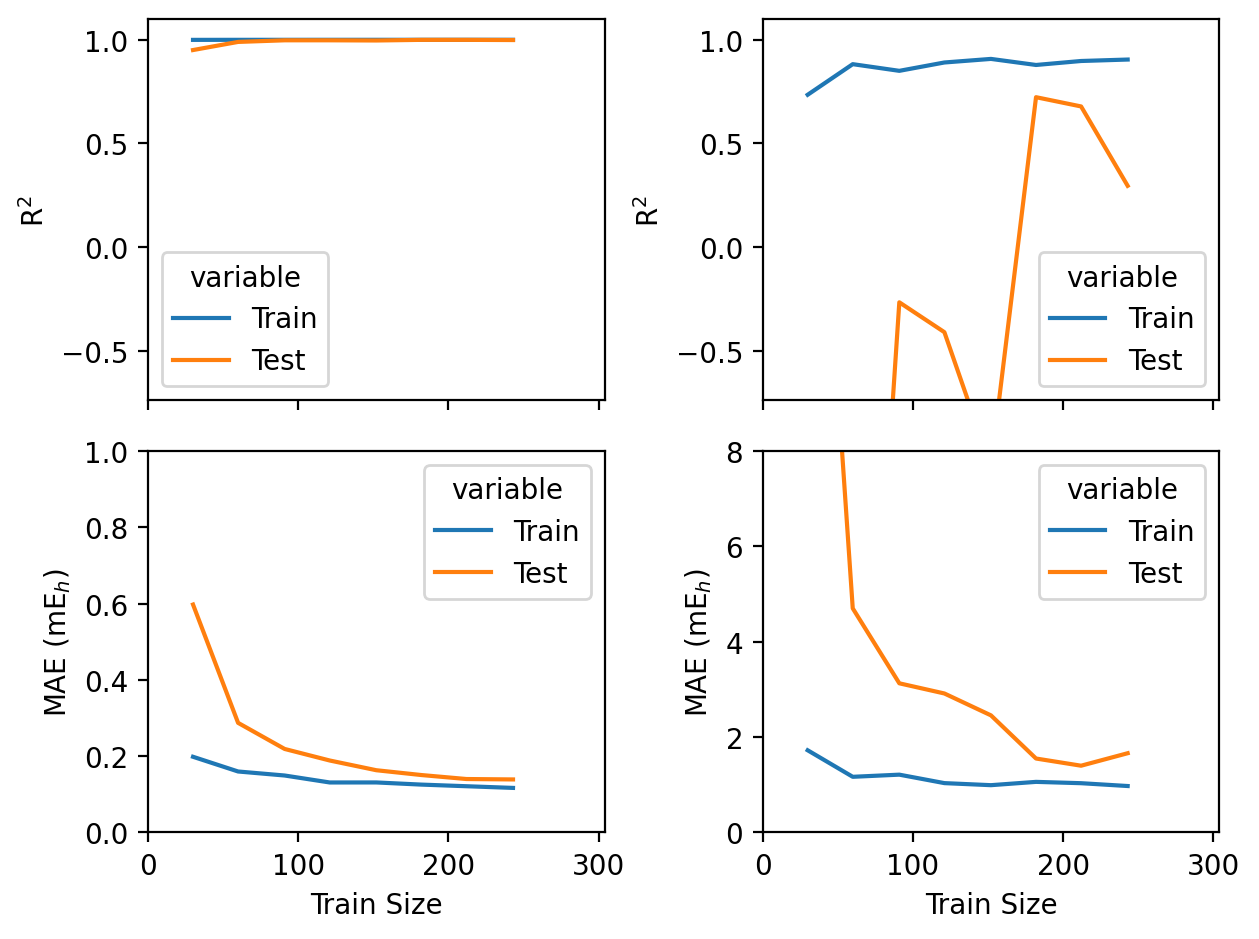

30 92
ANO-RCC-VTZP
R2: 0.9993,0.9664
RMSE (mEh): 0.2722,1.9264
60 92
ANO-RCC-VTZP
R2: 0.9995,0.9762
RMSE (mEh): 0.2331,1.6224
91 92
ANO-RCC-VTZP
R2: 0.9996,0.9793
RMSE (mEh): 0.2104,1.5140
121 92
ANO-RCC-VTZP
R2: 0.9996,0.9936
RMSE (mEh): 0.2103,0.8411
152 92
ANO-RCC-VTZP
R2: 0.9996,0.9950
RMSE (mEh): 0.2011,0.7465
182 92
ANO-RCC-VTZP
R2: 0.9997,0.9971
RMSE (mEh): 0.1933,0.5652
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395


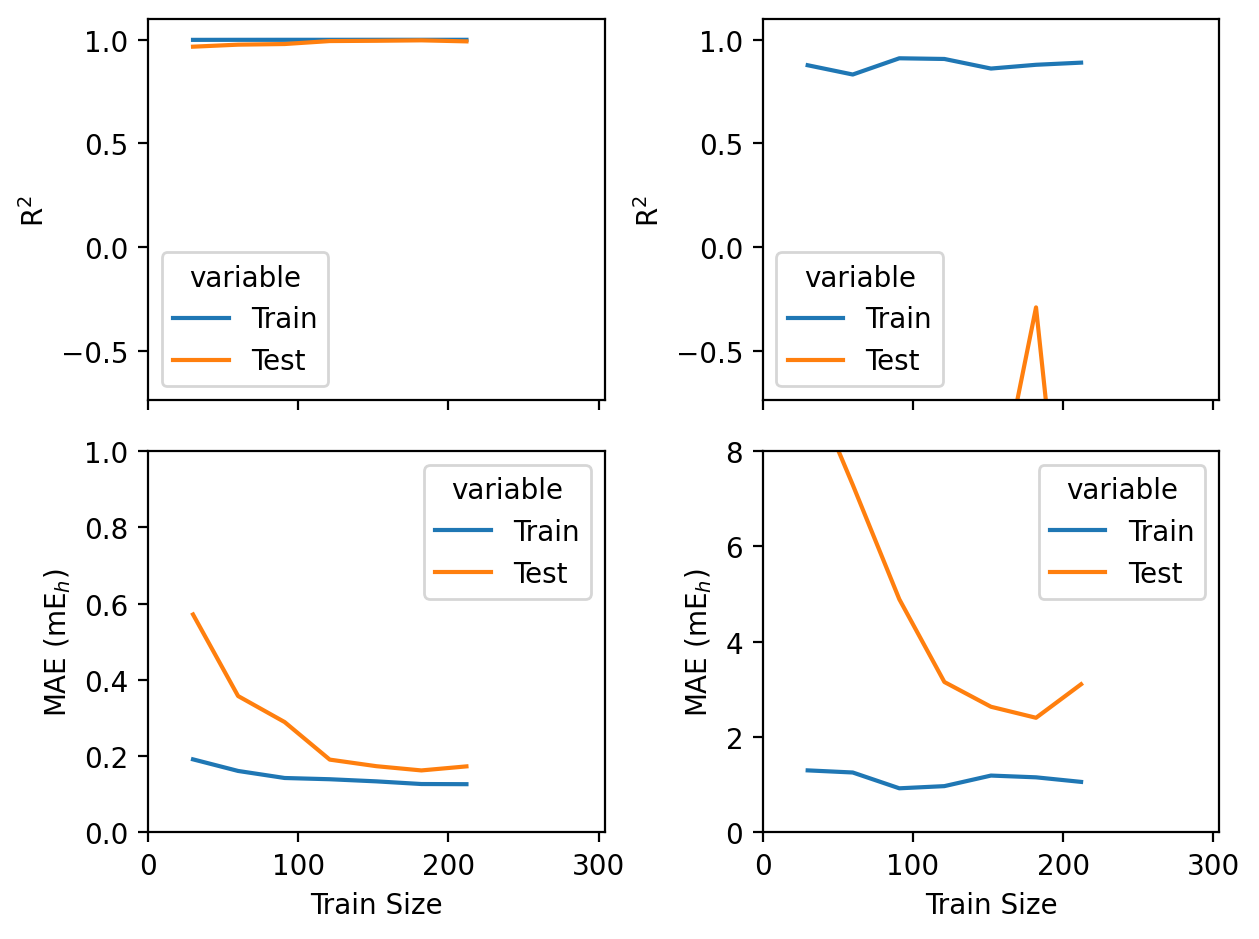

30 122
ANO-RCC-VTZP
R2: 0.9993,0.9458
RMSE (mEh): 0.2845,2.4455
60 122
ANO-RCC-VTZP
R2: 0.9995,0.9794
RMSE (mEh): 0.2285,1.5067
91 122
ANO-RCC-VTZP
R2: 0.9995,0.9863
RMSE (mEh): 0.2309,1.2286
121 122
ANO-RCC-VTZP
R2: 0.9995,0.9949
RMSE (mEh): 0.2280,0.7500
152 122
ANO-RCC-VTZP
R2: 0.9996,0.9955
RMSE (mEh): 0.2103,0.7078
182 122
ANO-RCC-VTZP
R2: 0.9996,0.9963
RMSE (mEh): 0.1995,0.6414


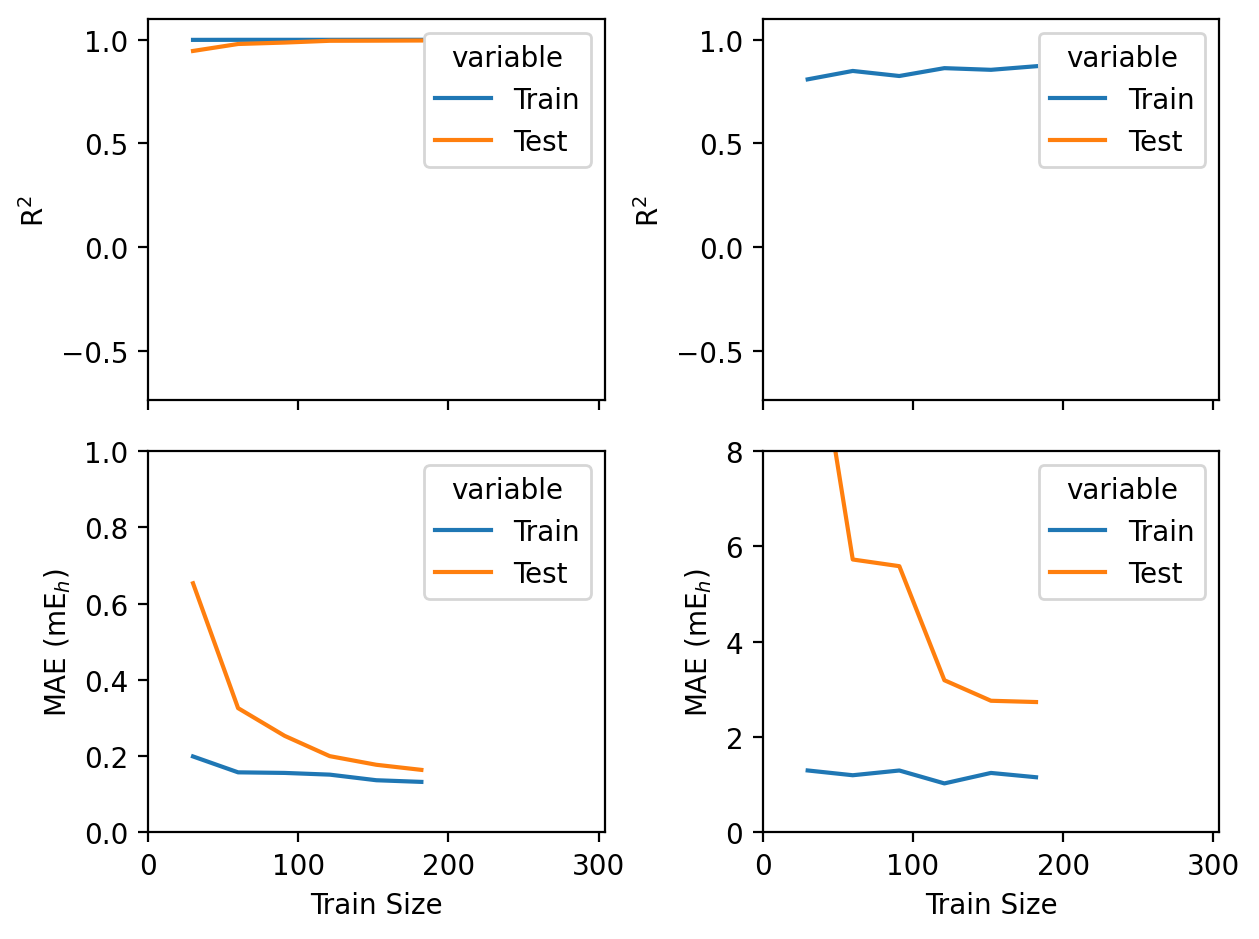

30 152
ANO-RCC-VTZP
R2: 0.9994,0.9547
RMSE (mEh): 0.2620,2.2346
60 152
ANO-RCC-VTZP
R2: 0.9994,0.9833
RMSE (mEh): 0.2551,1.3559
91 152
ANO-RCC-VTZP
R2: 0.9995,0.9901
RMSE (mEh): 0.2305,1.0449
121 152
ANO-RCC-VTZP
R2: 0.9996,0.9958
RMSE (mEh): 0.2224,0.6838
152 152
ANO-RCC-VTZP
R2: 0.9996,0.9930
RMSE (mEh): 0.2025,0.8770


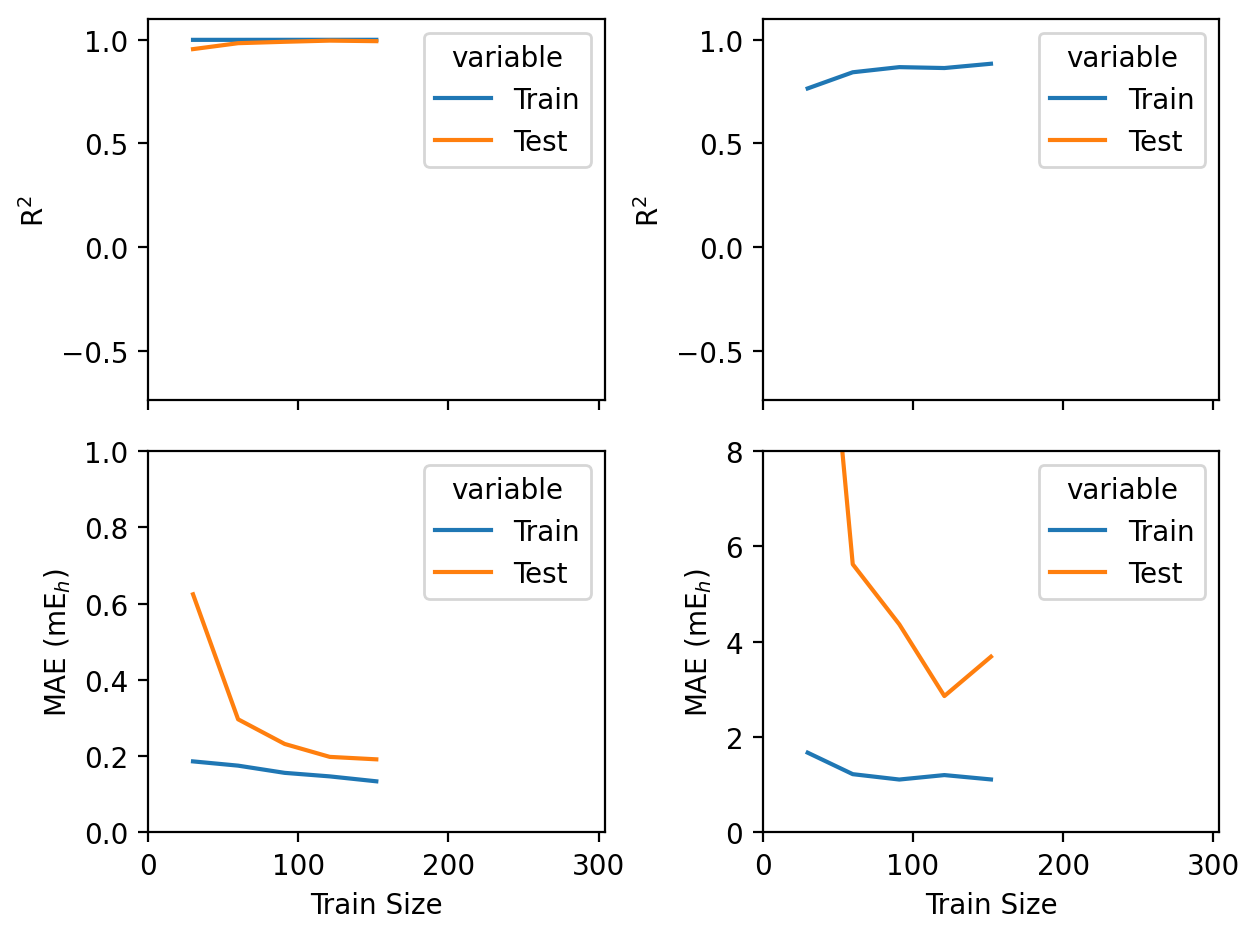

30 183
ANO-RCC-VTZP
R2: 0.9992,0.9613
RMSE (mEh): 0.2916,2.0663
60 183
ANO-RCC-VTZP
R2: 0.9994,0.9903
RMSE (mEh): 0.2518,1.0343
91 183
ANO-RCC-VTZP
R2: 0.9995,0.9936
RMSE (mEh): 0.2286,0.8366
121 183
ANO-RCC-VTZP
R2: 0.9996,0.9921
RMSE (mEh): 0.2207,0.9348


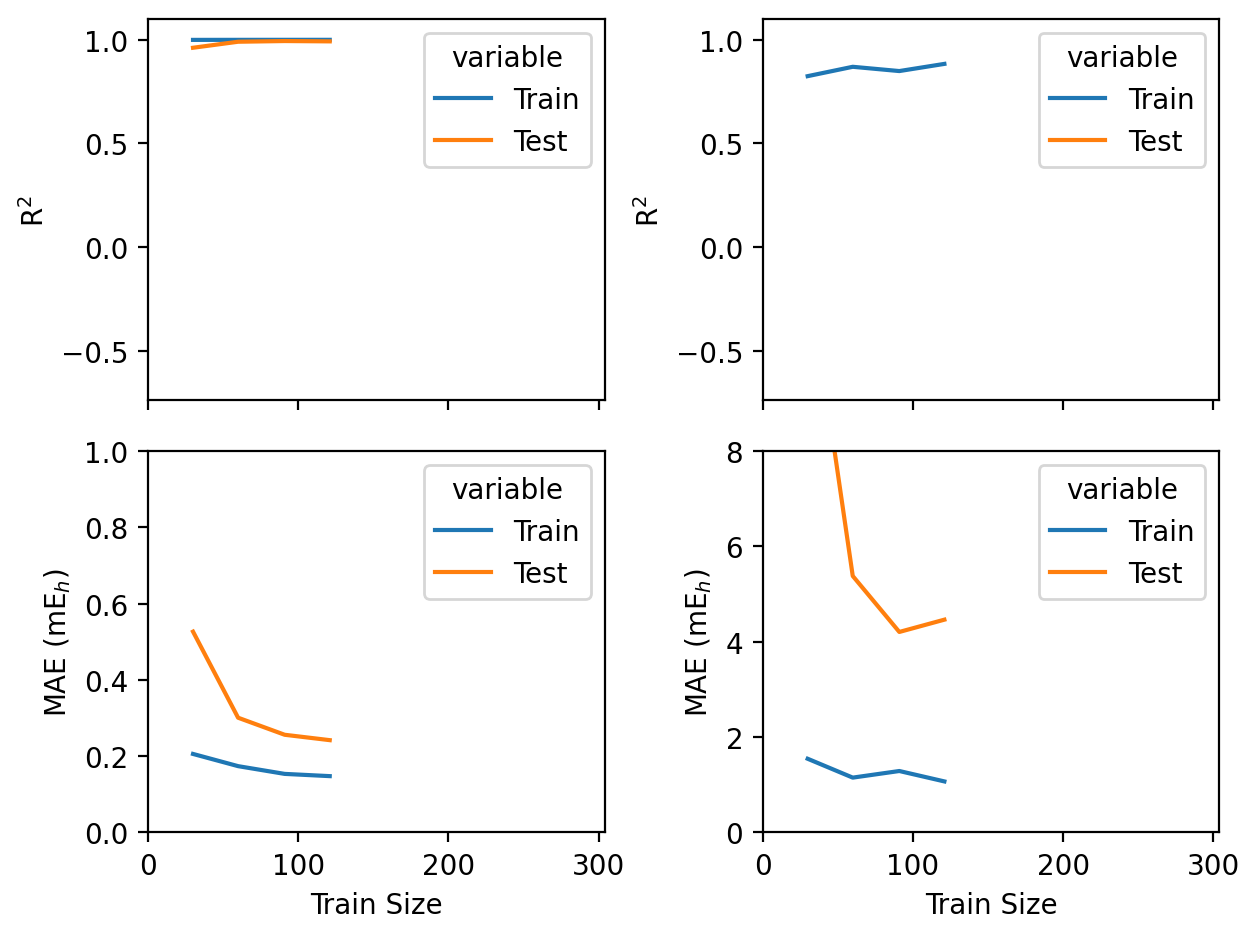

30 213
ANO-RCC-VTZP
R2: 0.9993,0.9543
RMSE (mEh): 0.2705,2.2418
60 213
ANO-RCC-VTZP
R2: 0.9995,0.9766
RMSE (mEh): 0.2273,1.6049
91 213
ANO-RCC-VTZP
R2: 0.9995,0.9883
RMSE (mEh): 0.2251,1.1340


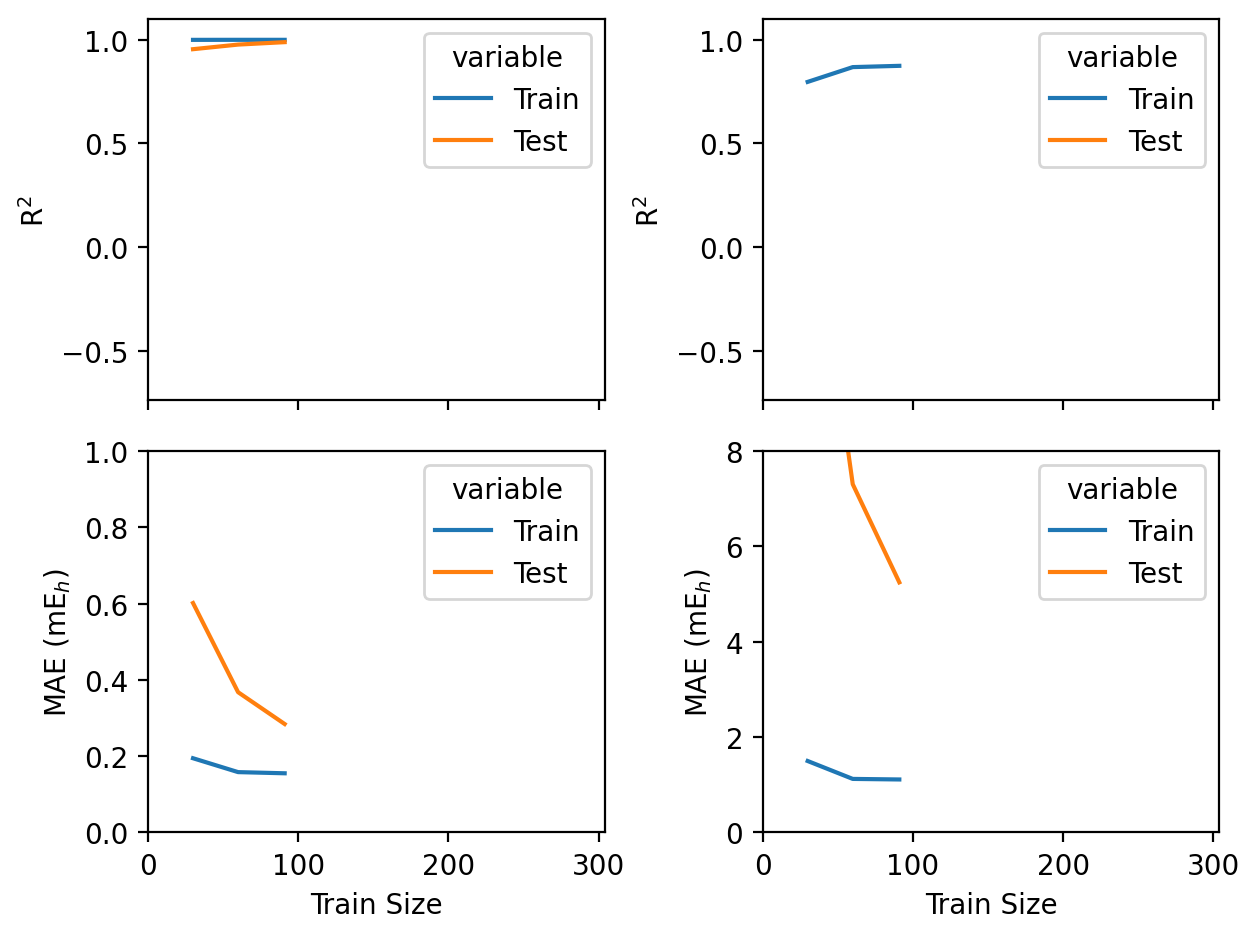

30 244
ANO-RCC-VTZP
R2: 0.9993,0.9669
RMSE (mEh): 0.2718,1.9097
60 244
ANO-RCC-VTZP
R2: 0.9995,0.9800
RMSE (mEh): 0.2357,1.4840


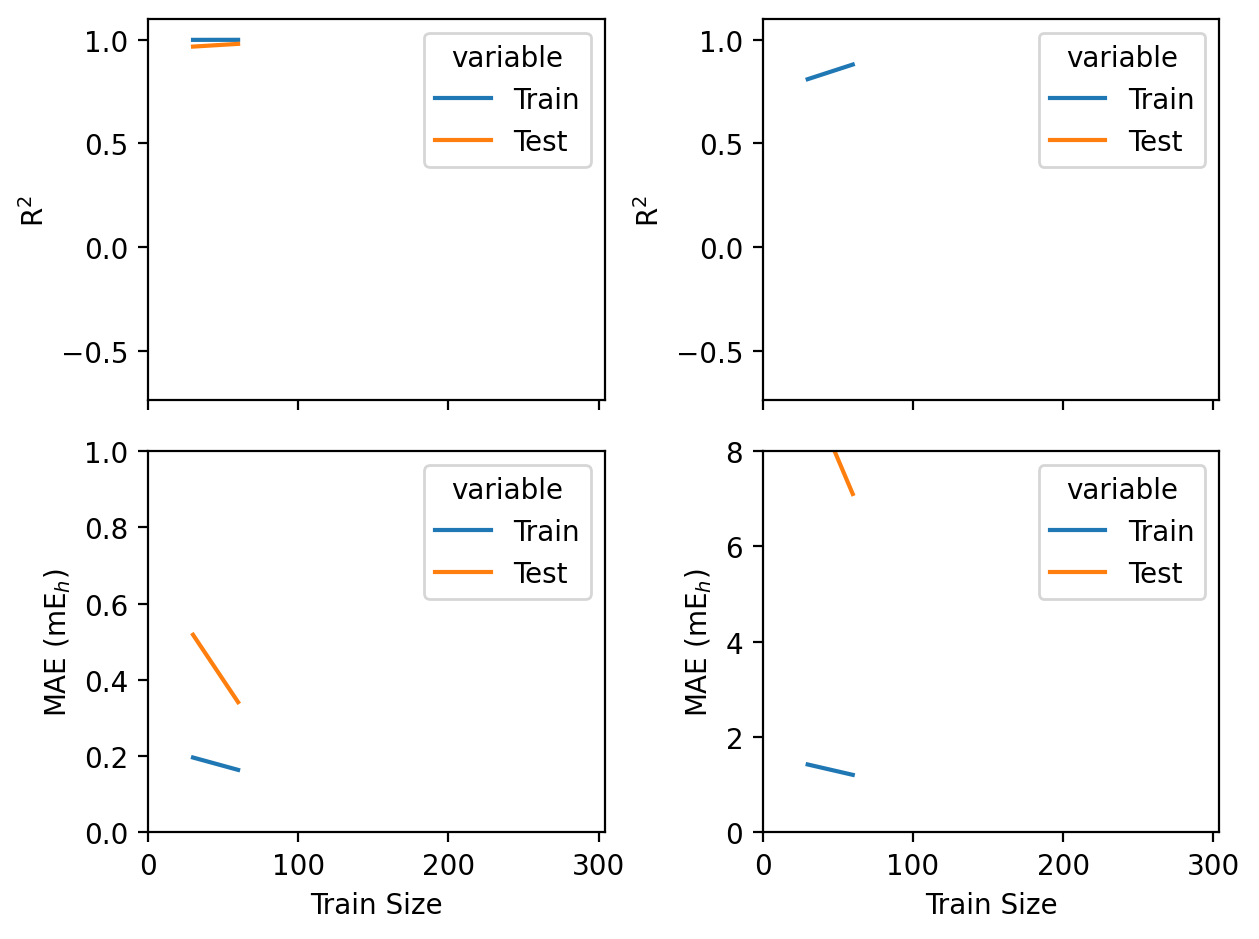

30 274
ANO-RCC-VTZP
R2: 0.9993,0.9436
RMSE (mEh): 0.2702,2.4929


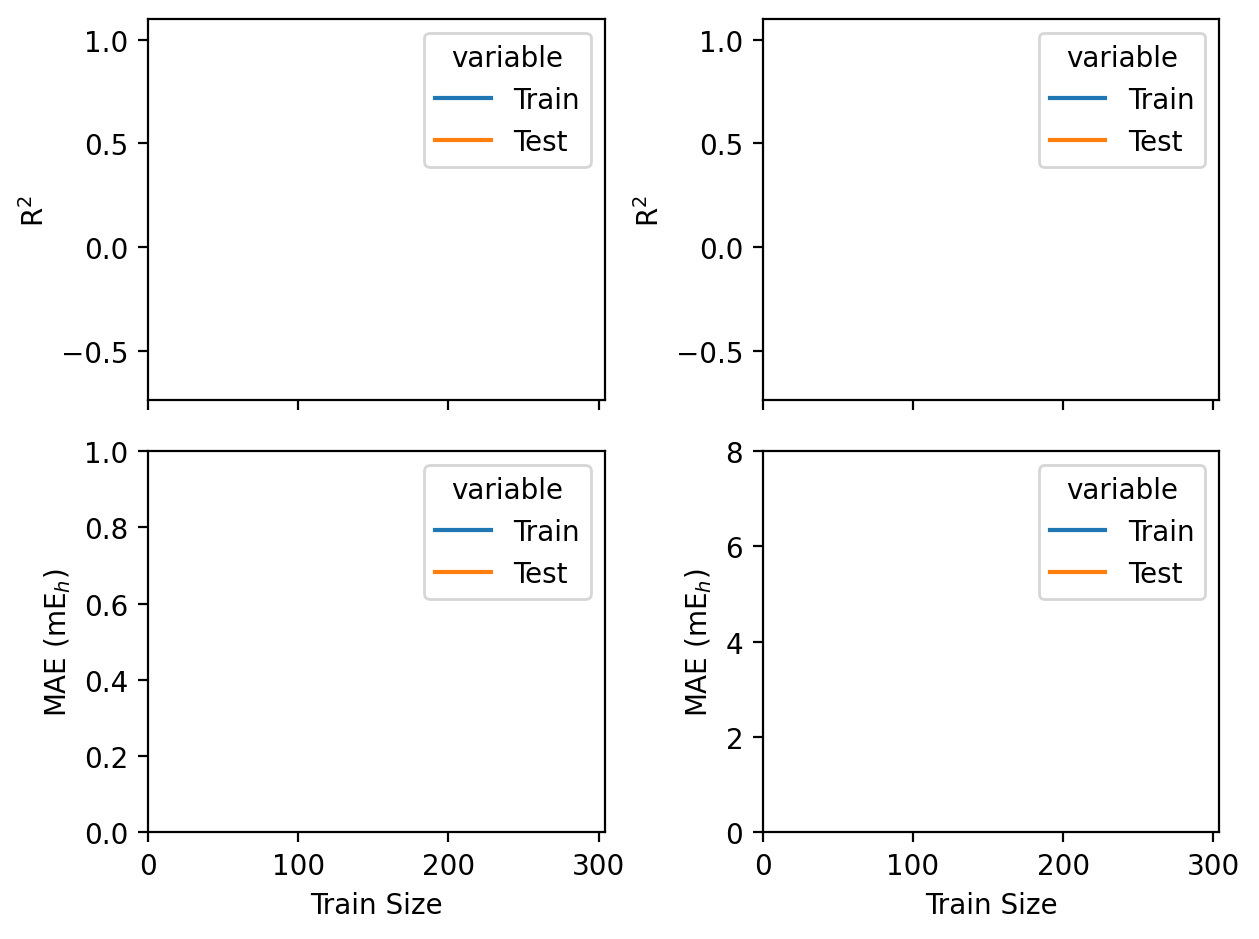

In [6]:

ranges=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,0.9]
for j in ranges:
    data = []
    for i in ranges:
        if j+i<=1:
            # print(i,j)
            data.append((int(i * 304),gen_lc(i,j)))
    plot(data,j)
    plt.show()
    


In [6]:
def gen_cut(cutoff):
    with open(os.path.join(os.path.expanduser('~'),'DDCASPT2/drop.txt'),'r') as d:
        dropfeat = [i.replace('\n','') for i in d.readlines()]

    with open('big_test_ind.pickle', 'rb') as handle:
        test_ind = pickle.load(handle)
    
    with open('big_train_ind.pickle', 'rb') as handle:
        train_ind = pickle.load(handle)
  
    train_ind = list(map(float,train_ind))
    test_ind = list(map(float,test_ind))
    train_ind, test_ind = train_test_split(train_ind+test_ind, test_size=0.3,random_state=42)
    print(len(train_ind),len(test_ind))    
    
    train = []
    test = []
        
    recover_train = []
    recover_test = []
    
    traincnt = 0
    testcnt = 0
    for i in sorted(glob('ANO-RCC-VTZP')):
        print(i)
        for j in glob(os.path.join(i,'ozone_*')):
            for k in train_ind:
                if f"{k:.2f}" in j:
                    traindf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                    traindf = traindf[traindf['Pair_Energies'].abs()>=cutoff]
                    train.append(traindf)
                    recover_train.append((i,f"{k:.2f}",traincnt,len(traindf)))
                    traincnt+=1
                    
            for l in test_ind:
                if f"{l:.2f}" in j:
                    testdf = pd.read_csv(os.path.join(j,os.path.basename(j)+'.csv'),compression='zip',index_col=0)
                    testdf = testdf[testdf['Pair_Energies'].abs()>=cutoff]
                    test.append(testdf)                    
                    recover_test.append((i,f"{l:.2f}",testcnt,len(testdf)))
                    testcnt+=1
                    
    rename = {'h$_{qq}^{0}$':'h$_{q}$',
    '$(F_{q})_{0}$':'$F_{q}$',
    '$(F_{q}^{\\text{SCF}})_{0}$':'$F_{q}^{\\text{SCF}}$',
    '$(\\eta_{q})_{0}$':'$\\eta_{q}$',
    '$(\\omega_{q})_{0}$':'$\\omega_{q}$',
    '$(\\eta_{s})_{0}$':'$\\eta_{s}$',
    'h$_{ss}^{0}$':'h$_{s}$',
    '$(F_{s}^{\\text{SCF}})_{0}$':'$F_{s}^{\\text{SCF}}$',
    '$(F_{s})_{0}$':'$F_{s}$',
    '$(\\omega_{s})_{0}$':'$\\omega_{s}$',
    '$(\\langle ss \\vert ss \\rangle)_{0}$':"$\\langle ss \\vert ss \\rangle$",
    '$(\\langle qq \\vert qq \\rangle)_{0}$':"$\langle qq \\vert qq \\rangle$",
    'h$_{pp}^{0}$': '(h$_{p}$)$_{0}$',
    'h$_{pp}^{1}$': '(h$_{p}$)$_{1}$',
    'h$_{pp}^{2}$': '(h$_{p}$)$_{2}$',
    'h$_{pp}^{3}$': '(h$_{p}$)$_{3}$',
    'h$_{rr}^{0}$': '(h$_{r}$)$_{0}$',
    'h$_{rr}^{1}$': '(h$_{r}$)$_{1}$',
    'h$_{rr}^{2}$': '(h$_{r}$)$_{2}$',
    'h$_{rr}^{3}$': '(h$_{r}$)$_{3}$',
    'h$_{pq}^{0}$':'(h$_{pq}$)$_{0}$',
    'h$_{pq}^{1}$':'(h$_{pq}$)$_{1}$',
    'h$_{pq}^{2}$':'(h$_{pq}$)$_{2}$',
    'h$_{pq}^{3}$':'(h$_{pq}$)$_{3}$',
    'h$_{pr}^{0}$':'(h$_{pr}$)$_{0}$',
    'h$_{pr}^{1}$':'(h$_{pr}$)$_{1}$',
    'h$_{pr}^{2}$':'(h$_{pr}$)$_{2}$',
    'h$_{pr}^{3}$':'(h$_{pr}$)$_{3}$',
    'h$_{rs}^{0}$':'(h$_{rs}$)$_{0}$',
    'h$_{rs}^{1}$':'(h$_{rs}$)$_{1}$',
    'h$_{rs}^{2}$':'(h$_{rs}$)$_{2}$',
    'h$_{rs}^{3}$':'(h$_{rs}$)$_{3}$',
    'typ_0':'type_0',
    'typ_1':'type_1',
    'typ_2':'type_2',
    'typ_3':'type_3'}
    
    train_df = pd.concat(train).drop(columns=dropfeat).rename(columns=rename)
    test_df = pd.concat(test).drop(columns=dropfeat).rename(columns=rename)
    
    X_train = train_df.drop(columns=['Pair_Energies']).values
    X_test = test_df.drop(columns=['Pair_Energies']).values
    
    y_train = train_df['Pair_Energies'].values
    y_test = test_df['Pair_Energies'].values
    
    scaler=MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)
    kwargs = dict(pd.read_excel("ozone_VTZP_params.xlsx").values)
    model=XGBRegressor(**kwargs)
    model.fit(X_train,y_train)
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
    print(f"RMSE (mEh): {root_mean_squared_error(y_train,y_pred_train)*1e3:.4f},{root_mean_squared_error(y_test,y_pred_test)*1e3:.4f}")
    
    testcntrcvr = 0
    recover_test_list = []
    recover_test_E2 = []
    for i,j,k,l in recover_test:
        init_test = testcntrcvr
        testcntrcvr+=l
        recover_test_list.append((i.split("_")[0],j,y_test[init_test:testcntrcvr],y_pred_test[init_test:testcntrcvr]))
        recover_test_E2.append((i.split("_")[0],j,np.sum(y_test[init_test:testcntrcvr]),np.sum(y_pred_test[init_test:testcntrcvr])))
    
    
    traincntrcvr = 0
    recover_train_list = []
    recover_train_E2 = []
    for i,j,k,l in recover_train:
        init_train = traincntrcvr
        traincntrcvr+=l
        recover_train_list.append((i.split("_")[0],j,y_train[init_train:traincntrcvr],y_pred_train[init_train:traincntrcvr]))
        recover_train_E2.append((i.split("_")[0],j,np.sum(y_train[init_train:traincntrcvr]),np.sum(y_pred_train[init_train:traincntrcvr])))
    
    traincorrE2 = pd.DataFrame(recover_train_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    testcorrE2 = pd.DataFrame(recover_test_E2).rename(columns={0:"basis set",1:'Angle ($^{\circ}$)',2:'E$_{2}^{\text{Calculated}}$',3:'E$_{2}^{\text{Predicted}}$'})
    #.astype({"basis set":str,'Angle ($^{\circ}$)':float,'E$_{2}^{\text{Calculated}}$':float,'E$_{2}^{\text{Predicted}}$':float})
    
    traincorrE2['CASPT2_E']=np.zeros(len(traincorrE2))
    traincorrE2['CASSCF_E']=np.zeros(len(traincorrE2))
    traincorrE2['E2']=np.zeros(len(traincorrE2))
    
    traincorrE2.index = ["_".join((u,v)) for u,v in traincorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in traincorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
        traincorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        traincorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # traincorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    traincorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = traincorrE2['CASSCF_E']+traincorrE2['E$_{2}^{\text{Predicted}}$']
    
    traincorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    
    
    testcorrE2['CASPT2_E']=np.zeros(len(testcorrE2))
    testcorrE2['CASSCF_E']=np.zeros(len(testcorrE2))
    testcorrE2['E2']=np.zeros(len(testcorrE2))
    
    testcorrE2.index = ["_".join((u,v)) for u,v in testcorrE2[["basis set",'Angle ($^{\circ}$)']].values]
    
    for i in testcorrE2.index:
        hn, r = i.split('_')
        energy_df = pd.read_excel(f"{hn}/ozone_{r}/ozone_{r}_energies.xlsx",index_col=0)
        testcorrE2.loc[i,'CASPT2_E']=energy_df.loc['CASPT2_E'].values
        testcorrE2.loc[i,'CASSCF_E']=energy_df.loc['CASSCF_E'].values
        # testcorrE2.loc[i,'E2']=energy_df.loc['E2'].values
    
    testcorrE2['E$_{\text{CASPT2}}^{\text{Predicted}}$'] = testcorrE2['CASSCF_E']+testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    testcorrE2.rename(columns = {'CASPT2_E':'E$_{\text{CASPT2}}^{\text{Calculated}}$','CASSCF_E':'E$_{\text{CASSCF}}^{\text{Calculated}}$'},inplace=True)
    return ((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))

In [7]:
14-3

11

In [8]:
data = []
for i in np.logspace(-14,-3,12):
    print(i)
    data.append((i,gen_cut(i)))


pair_r2 = []
pair_mae = []
corr_r2 = []
corr_mae = []
for (i,((y_train,y_pred_train), (y_test,y_pred_test), (traincorrE2, testcorrE2))) in data:
    traincorrE2_true = traincorrE2['E$_{2}^{\text{Calculated}}$']
    traincorrE2_pred = traincorrE2['E$_{2}^{\text{Predicted}}$']

    testcorrE2_true = testcorrE2['E$_{2}^{\text{Calculated}}$']
    testcorrE2_pred = testcorrE2['E$_{2}^{\text{Predicted}}$']
    
    pair_r2.append((i,r2_score(y_train,y_pred_train),r2_score(y_test,y_pred_test)))
    pair_mae.append((i,1e3 * mean_absolute_error(y_train,y_pred_train),1e3 * mean_absolute_error(y_test,y_pred_test)))

    corr_r2.append((i,r2_score(traincorrE2_true,traincorrE2_pred),r2_score(testcorrE2_true,testcorrE2_pred)))
    corr_mae.append((i,1e3 * mean_absolute_error(traincorrE2_true,traincorrE2_pred),1e3 * mean_absolute_error(testcorrE2_true,testcorrE2_pred)))

dfpair_r2 = pd.DataFrame(pair_r2,columns=['Cutoff', "Train", "Test"])
dfcorr_r2 = pd.DataFrame(corr_r2,columns=['Cutoff', "Train", "Test"])
dfpair_mae = pd.DataFrame(pair_mae,columns=['Cutoff', "Train", "Test"])
dfcorr_mae = pd.DataFrame(corr_mae,columns=['Cutoff', "Train", "Test"])




1e-14
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-13
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-12
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-11
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-10
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-09
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-08
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-07
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
1e-06
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
9.999999999999999e-06
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9920
RMSE (mEh): 0.1918,0.9395
0.0001
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9947
RMSE (mEh): 0.1890,0.7639
0.001
212 92
ANO-RCC-VTZP
R2: 0.9997,0.9970
RMSE (mEh): 0.1858,0.5838


In [9]:
dfpair_r2

,Cutoff,Train,Test
0,1.000000e-14,0.999666,0.992015
1,1.000000e-13,0.999666,0.992015
2,1.000000e-12,0.999666,0.992015
3,1.000000e-11,0.999666,0.992015
4,1.000000e-10,0.999666,0.992015
5,1.000000e-09,0.999666,0.992015
6,1.000000e-08,0.999666,0.992015
7,1.000000e-07,0.999666,0.992015
8,1.000000e-06,0.999666,0.992015
9,1.000000e-05,0.999666,0.992015


/tmp/ipykernel_88389/491925430.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0][0].set_xlim(10**-15,0)


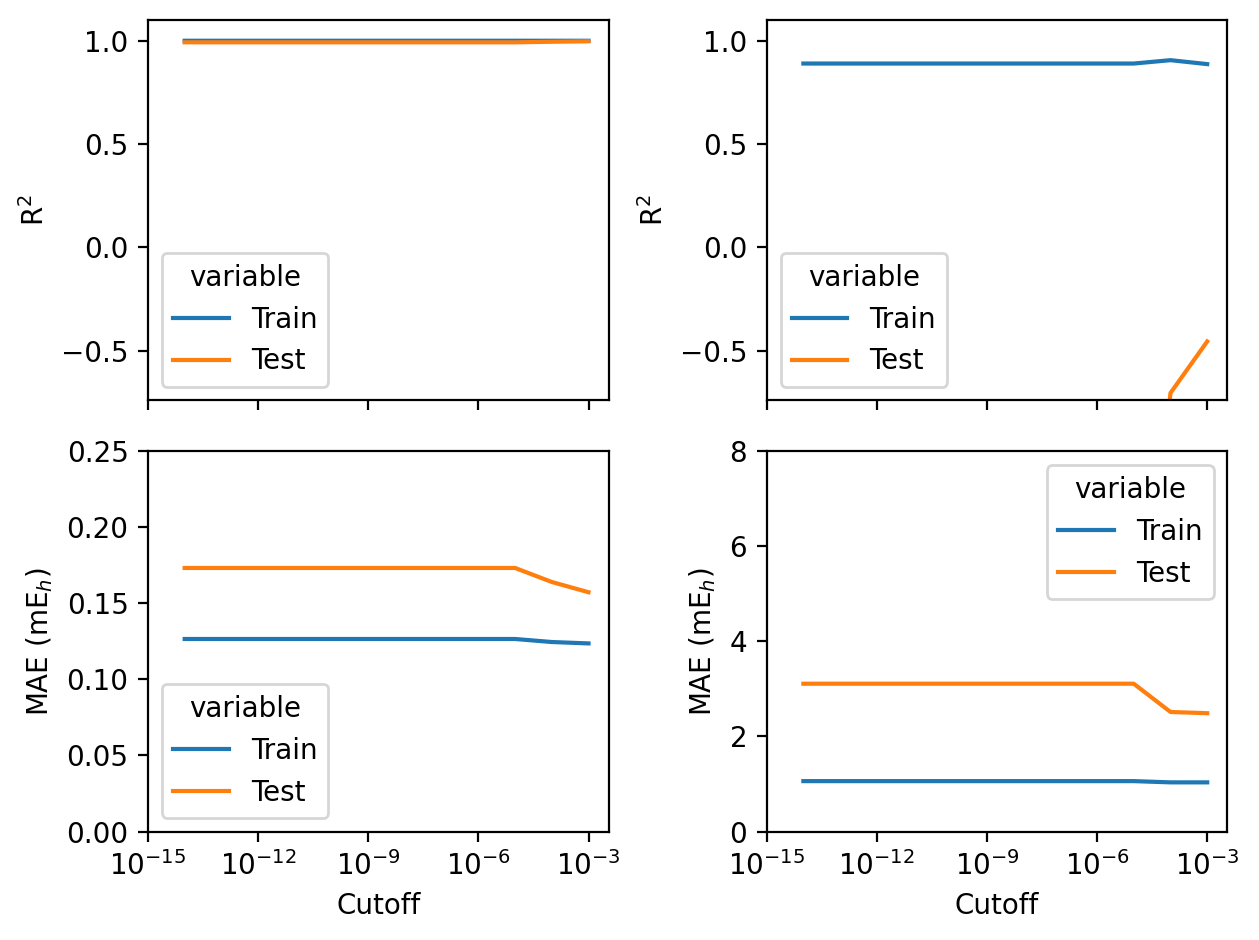

In [10]:
fig, ax = plt.subplots(2,2,sharex=True)
sns.lineplot(dfpair_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][0])
sns.lineplot(dfcorr_r2.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[0][1],markers='x')
# ax[0][0].set_xlim(0,500)
# ax[0][1].set_xlim(0,500)
ax[0][0].set_xscale("log")
ax[0][1].set_xscale("log")
ax[0][0].set_ylim(-.74,1.1)
ax[0][1].set_ylim(-.74,1.1)
ax[0][0].set_xlim(10**-15,0)
# ax[0][1].set_xlim(-.74,1.1)
ax[0][0].set_ylabel("R$^{2}$")
ax[0][1].set_ylabel("R$^{2}$")
sns.lineplot(dfpair_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][0])
ax[1][0].set_ylim(0,0.25)
sns.lineplot(dfcorr_mae.melt(id_vars='Cutoff',value_vars=['Train','Test']),x='Cutoff',y='value', hue='variable',ax=ax[1][1])
ax[1][1].set_ylim(0,8)
ax[1][0].set_ylabel("MAE (mE$_{h}$)")
ax[1][1].set_ylabel("MAE (mE$_{h}$)")
plt.tight_layout()
# plt.savefig('images/cutoff_curves.png',dpi=300,bbox_inches='tight')

In [11]:
dfcorr_r2.sort_values(by=['Train','Test'])

,Cutoff,Train,Test
11,1.000000e-03,0.886646,-0.454806
0,1.000000e-14,0.889424,-2.347011
1,1.000000e-13,0.889424,-2.347011
2,1.000000e-12,0.889424,-2.347011
3,1.000000e-11,0.889424,-2.347011
4,1.000000e-10,0.889424,-2.347011
5,1.000000e-09,0.889424,-2.347011
6,1.000000e-08,0.889424,-2.347011
7,1.000000e-07,0.889424,-2.347011
8,1.000000e-06,0.889424,-2.347011
